# NYC Jan 2015 Yellow Cab Taxi Data

dowload to all nodes in the cluster from: https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-01.csv

In [55]:
from dask.distributed import Client, Executor, progress
from dask import dataframe as dd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# enable matplotlib to display inline
%matplotlib inline

In [2]:
client = Client('10.10.100.15:8786')

In [3]:
client

<Client: scheduler='tcp://10.10.100.15:8786' processes=18 cores=18>

In [30]:
# create the dataframe by reading in the CSV
csv = '/root/yellow_tripdata_2015-01.csv'

# load the csv file into a dask dataframe
df = dd.read_csv(csv, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
df = client.persist(df)
progress(df)

In [31]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [32]:
len(df)

12748986

In [33]:
df.groupby(df.passenger_count).trip_distance.mean().compute()

passenger_count
0     2.162647
1    14.826122
2    18.040789
3     2.852763
4     2.871686
5     2.856184
6     2.788518
9     7.269091
7     2.566667
8     2.179000
Name: trip_distance, dtype: float64

In [34]:
df2 = df[(df.tip_amount > 0) & (df.fare_amount > 0)]    # filter out bad rows
df2['tip_fraction'] = df2.tip_amount / df2.fare_amount  # make new column

In [35]:
df2['tpep_pickup_datetime']

Dask Series Structure:
npartitions=32
None    datetime64[ns]
None               ...
             ...      
None               ...
None               ...
Name: tpep_pickup_datetime, dtype: datetime64[ns]
Dask Name: getitem, 384 tasks

In [36]:
dayofweek = (df2.groupby(df2.tpep_pickup_datetime.dt.weekday_name).tip_fraction.mean())
hour      = (df2.groupby(df2.tpep_pickup_datetime.dt.hour).tip_fraction.mean())

In [37]:
hour

Dask Series Structure:
npartitions=1
None    float64
None        ...
Name: tip_fraction, dtype: float64
Dask Name: truediv, 491 tasks

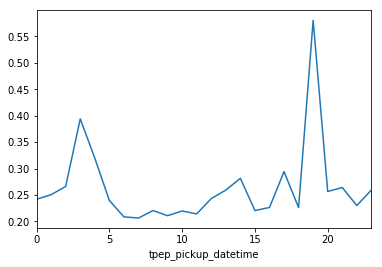

In [51]:
hour.head(24).plot()

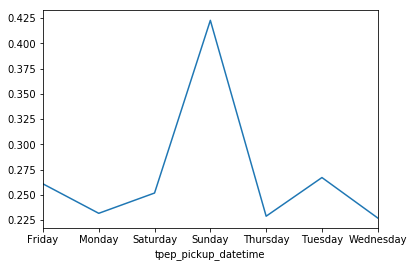

In [52]:
dayofweek.head(7).plot()

In [63]:
payments = pd.DataFrame({1: 'Credit Card', 
                         2: 'Cash', 
                         3: 'No Charge', 
                         4: 'Dispute', 
                         5: 'Unknown', 
                         6: 'Voided trip'}, index=[0])

In [71]:
payment_types = {1: 'Credit Card', 
                         2: 'Cash', 
                         3: 'No Charge', 
                         4: 'Dispute', 
                         5: 'Unknown', 
                         6: 'Voided trip'}

In [73]:
df2['payment_name'] = df2['payment_type'].map(payment_types)

In [74]:
df2.groupby(df2.payment_name).tip_amount.mean().compute()

payment_name
Cash           5.591196
Credit Card    3.103898
Dispute        1.855833
No Charge      3.987778
Name: tip_amount, dtype: float64

In [68]:
df2.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,tip_fraction
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.00,0.3,17.05,0.270833
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.00,0.3,17.80,0.137931
5,1,2015-01-10 20:33:39,2015-01-10 20:53:52,1,9.00,-73.874374,40.774048,1,N,-73.986977,40.758194,1,27.0,0.5,0.5,6.70,5.33,0.3,40.33,0.248148
7,1,2015-01-10 20:33:39,2015-01-10 20:42:20,3,0.80,-74.002663,40.734142,1,N,-73.995010,40.726326,1,7.0,0.5,0.5,1.66,0.00,0.3,9.96,0.237143
9,1,2015-01-10 20:33:40,2015-01-10 20:40:44,2,0.90,-73.985588,40.767948,1,N,-73.985916,40.759365,1,6.5,0.5,0.5,1.55,0.00,0.3,9.35,0.238462


In [75]:
df['payment_name'] = df['payment_type'].map(payment_types)

In [76]:
df.groupby(df.payment_name).tip_amount.mean().compute()

payment_name
Cash           0.000214
Credit Card    2.998640
Dispute       -0.021116
No Charge      0.000591
Unknown        0.000000
Name: tip_amount, dtype: float64

In [77]:
zero_tip = df.tip_amount == 0
cash     = df.payment_name == 'Cash'

dd.concat([zero_tip, cash], axis=1).corr().compute()

/root/anaconda3/lib/python3.6/site-packages/dask/dataframe/multi.py:568: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
aligned. This assumption is not generally safe.
  warn("Concatenating dataframes with unknown divisions.\n"


,tip_amount,payment_name
tip_amount,1.000000,0.948438
payment_name,0.948438,1.000000


In [79]:
df3 = client.persist(df.set_index('tpep_pickup_datetime'))

In [80]:
df3.head()

,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_name
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,1,2015-01-01 00:11:26,5,4.00,-73.971436,40.760201,1,N,-73.921181,40.768269,2,13.5,0.5,0.5,0.0,0.0,0.0,14.5,Cash
2015-01-01 00:00:00,2,2015-01-01 00:00:00,3,1.56,-74.001320,40.729057,1,N,-74.010208,40.719662,1,7.5,0.5,0.5,0.0,0.0,0.3,8.8,Credit Card
2015-01-01 00:00:00,2,2015-01-01 00:00:00,1,1.68,-73.991547,40.750069,1,N,0.000000,0.000000,2,10.0,0.0,0.5,0.0,0.0,0.3,10.8,Cash
2015-01-01 00:00:01,1,2015-01-01 00:03:49,1,0.80,-73.860847,40.757294,1,N,-73.868111,40.752285,2,5.0,0.5,0.5,0.0,0.0,0.0,6.3,Cash
2015-01-01 00:00:03,2,2015-01-01 00:10:50,1,1.58,-73.987579,40.765270,1,N,-73.976921,40.776970,1,9.0,0.5,0.5,1.9,0.0,0.3,12.2,Credit Card


In [81]:
df3.tail()

,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_name
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,
2015-01-31 23:59:59,2,2015-02-01 00:05:23,5,0.98,-73.993507,40.682220,1,N,-73.985748,40.692341,2,6.0,0.5,0.5,0.0,0.0,0.3,7.3,Cash
2015-01-31 23:59:59,2,2015-02-01 00:13:41,1,2.43,-73.990692,40.730648,1,N,-73.977646,40.759628,2,11.5,0.5,0.5,0.0,0.0,0.3,12.8,Cash
2015-01-31 23:59:59,2,2015-02-01 00:24:39,1,7.79,-73.789810,40.643711,1,N,-73.881340,40.676056,2,25.5,0.5,0.5,0.0,0.0,0.3,26.8,Cash
2015-01-31 23:59:59,2,2015-02-01 00:19:40,1,3.47,-73.996292,40.746910,1,N,-73.954620,40.765614,1,15.5,0.5,0.5,3.0,0.0,0.3,19.8,Credit Card
2015-01-31 23:59:59,2,2015-02-01 00:25:54,3,3.26,-73.971092,40.755676,1,N,-73.995338,40.717506,1,17.5,0.5,0.5,2.0,0.0,0.3,20.8,Credit Card


In [83]:
df3.loc['2015-01-05'].head()

,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_name
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,
2015-01-05 00:00:00,1,2015-01-05 00:09:43,1,3.00,-73.990952,40.686058,1,N,-73.938622,40.677547,1,11.0,0.5,0.5,2.00,0.0,0.3,14.30,Credit Card
2015-01-05 00:00:00,2,2015-01-05 10:34:39,2,0.00,0.000000,0.000000,5,N,-73.770699,41.033516,1,129.0,0.0,0.0,25.80,0.0,0.0,154.80,Credit Card
2015-01-05 00:00:01,2,2015-01-05 00:18:08,1,3.44,-73.963882,40.710274,1,N,-73.972992,40.675133,1,14.5,0.5,0.5,4.00,0.0,0.3,19.80,Credit Card
2015-01-05 00:00:03,1,2015-01-05 00:10:23,1,2.20,-73.994064,40.751030,1,N,-73.982750,40.731388,1,10.0,0.5,0.5,2.26,0.0,0.3,13.56,Credit Card
2015-01-05 00:00:03,1,2015-01-05 00:03:20,1,0.60,-73.989716,40.756626,1,N,-73.991776,40.750034,1,4.5,0.5,0.5,1.15,0.0,0.3,6.95,Credit Card


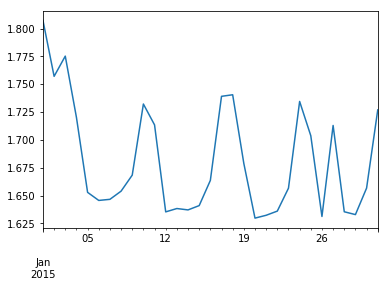

In [84]:
(df3.passenger_count
       .resample('1d')
       .mean()
       .compute()
       .plot())

In [85]:
s = client.persist(df.passenger_count.rolling(10).mean())